In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import tqdm
import numpy as np

# Add project to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from lib.generate.generate_ar import simulate_ar
from lib.models.ArModale import ArModel
from lib.generate.generate_ar import generate_stationary_ar_coefficients
from lib.loss.Mse import Mse
from lib.dataprocessor.ArDataProcessor import ArDataProcessor
from lib.analysis.ModelResult import ModelResult
from lib.analysis.analyze import analyze_simulations, get_best_model_distribution
from lib.analysis.plot import plot_error_density, plot_max_error_for_alpha_kde, plot_error_quantiles_and_mean, \
    plot_log_error_quantiles_and_mean_with_regression

In [4]:
def run_n_simulation(models, oracle_coefficients, loss, sigma, length, data_processor, n=20, train_ratio=0.6, theo_risk_estimator_length=10**6, seed=1):
    theo_risk_series = simulate_ar(oracle_coefficients, sigma, theo_risk_estimator_length, seed=seed)
    x_theo_risk, y_theo_risk = data_processor.process(theo_risk_series)
    
    train_length = int(train_ratio * length)
    test_length = length - train_length
    simulations = {}
    for i in tqdm.tqdm(range(n)):
        simulation = {}
        # Generate data
        series = simulate_ar(oracle_coefficients, sigma, length, seed=seed+i)
        # Process data
        x, y = data_processor.process(series)
        x_train, y_train = x[:train_length], y[:train_length]
        x_test, y_test = x[train_length:], y[train_length:]
        # Fit models
        for model in models:
            model = model.fit(x_train, y_train)
            model_loss_all_test = loss.compute(model.predict(x_test), y_test)
            model_theo_risk_loss = loss.compute(model.predict(x_theo_risk), y_theo_risk)
            model_theo_risk = model_theo_risk_loss.mean()
            simulation[model.name] = ModelResult(model.name, np.ravel(model_loss_all_test), model_theo_risk)
        simulations[i] = simulation
    return simulations, test_length
        

In [8]:
length = 10**4
sigma = 0.1
degree = 5
max_degree = 50

models = [ArModel(i) for i in range(1, max_degree)]
oracle_coefficients = generate_stationary_ar_coefficients(degree=degree, seed=1)
loss = Mse()
data_processor = ArDataProcessor('ar', max_degree)

simulations, test_length = run_n_simulation(models, oracle_coefficients, loss, sigma, length, data_processor, n=10, train_ratio=0.6, theo_risk_estimator_length=10**7, seed=1)

100%|██████████| 10/10 [02:00<00:00, 12.08s/it]


In [9]:
simulations_analysis = analyze_simulations(simulations, test_length)  
model_distribution = get_best_model_distribution(simulations_analysis, test_length)

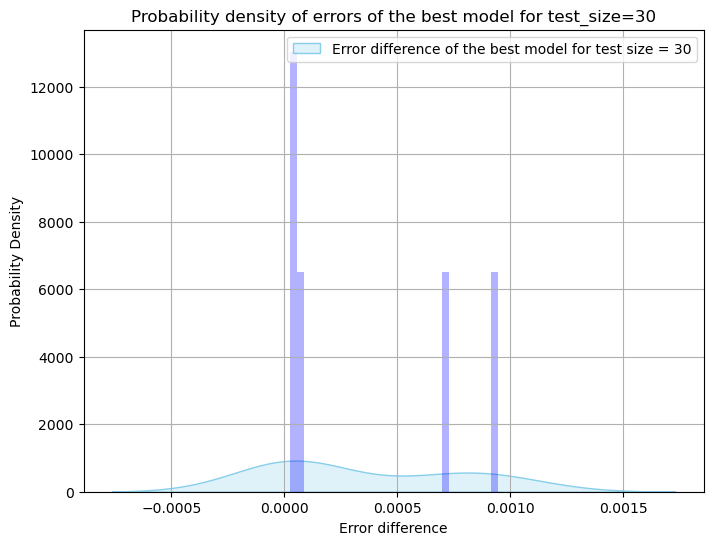

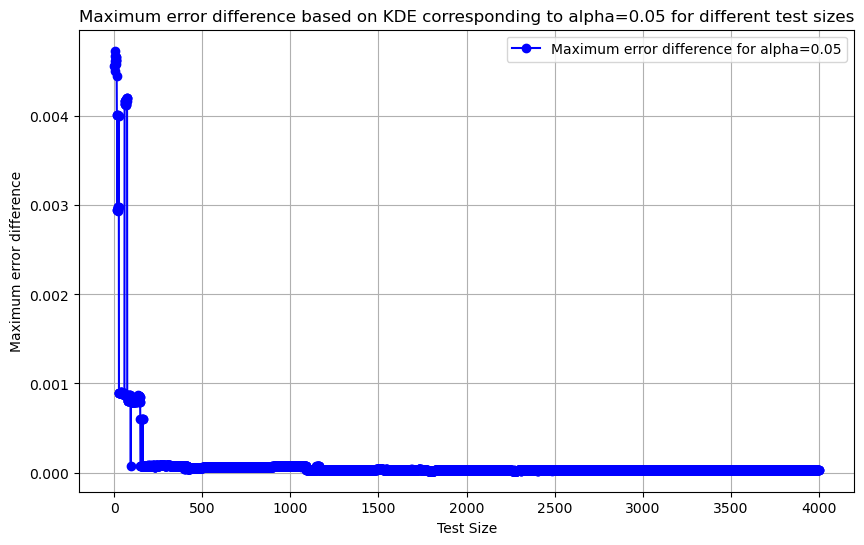

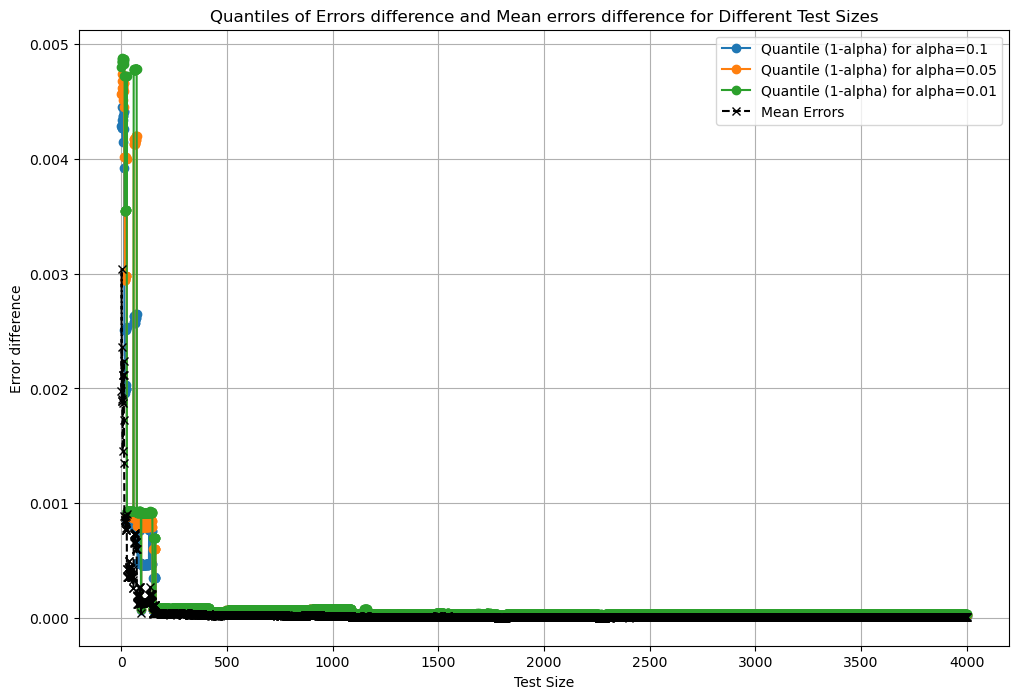

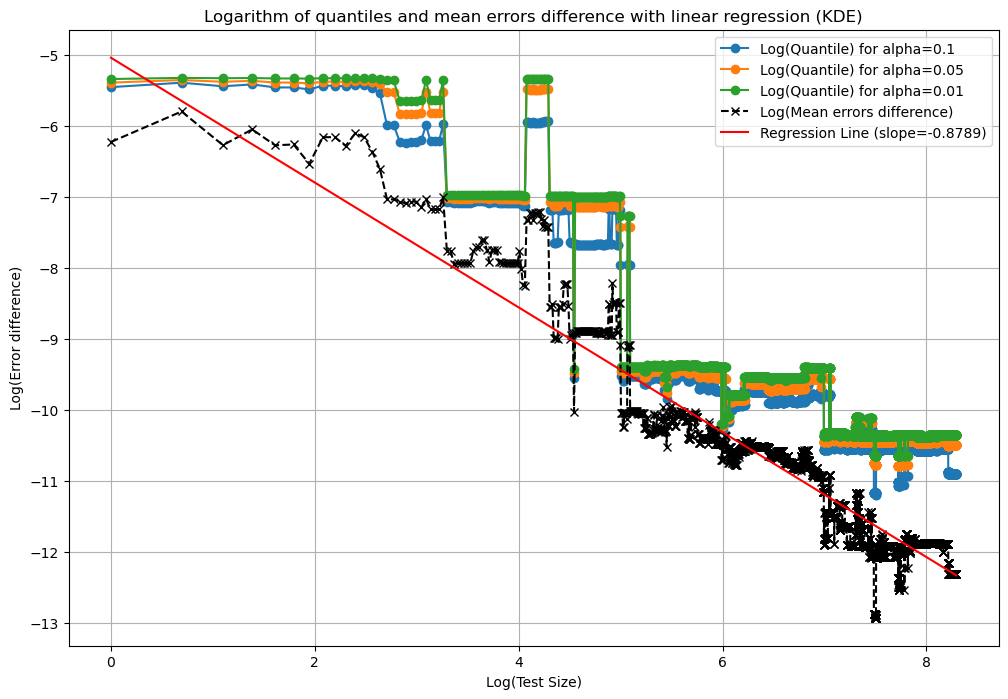

(-0.8789307393316894, -5.038686260804035)

In [10]:
plot_error_density(model_distribution, test_size=30)
plot_max_error_for_alpha_kde(model_distribution, alpha=0.05)
alphas = [0.1, 0.05, 0.01]
plot_error_quantiles_and_mean(model_distribution, alphas)
plot_log_error_quantiles_and_mean_with_regression(model_distribution, alphas)

# Oracle Bounds for out-of-sample risk in time series with exogenous variables
 

## Experimental section

### Objective : 
The objective of this section is to illustrate the oracle inequalities of theorem 2.1 for the out-of-sample risk in time series.
The idea is to observe the variation of the different between the theoretical risks of the empirical best model and the theoretical risk of the best model in the class of models as a function of the size of the test set.

### Methodology :
To do this :
    we chose a model AR(p) with a fixed coefficient vector
    we execute the following steps n times :
        we iterate over the test_size from 1 to max_test_size :
            we generate a time series from an AR(p) model
            we split the time series into a training set and a test set
            we train lambda models of degrees from 1 to lambda
            we select the model with the smallest empirical risk and save its theoretical risk (estimated on a large time series)
    
    we then observe :
        the distribution of the theoretical risks of the best models for each test_size via a KDE filter
        
        the maximum error for a given probability alpha as a function of the size of the test set
        
        the logarithm of the maximum error for a given probability alpha as a function of the logarithm of the size of the test set
        the regression line of the logarithm of the maximum error for a given probability alpha as a function of the logarithm of the size of the test set
    

